In [1]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tensor
spikes_tensor = torch.load("C:/Users/dines/Capstone Project/tensors/spike_data_tensor.pt" ,map_location=device)
labels_tensor = torch.load("C:/Users/dines/Capstone Project/tensors/labels_tensor.pt", map_location=device)

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

spikes_tensor = spikes_tensor.to(device)
labels_tensor = labels_tensor.to(device)

Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


In [3]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

### Dataset and DataLoader Configuration

In [4]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [5]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836])


In [6]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [7]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  # Number of input channels
n_classes = 1    # Number of output classes (assuming a binary classification task)
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

net = SynNet(
    #p_dropout = 0.1,
    n_channels=n_channels,                        
    n_classes=n_classes,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8]
)

print(net)

c:\Users\dines\miniconda3\envs\capstone\lib\site-packages\rockpool\nn\networks\__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
c:\Users\dines\miniconda3\envs\capstone\lib\site-packages\rockpool\nn\networks\__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


### Train & Validation

  2%|▏         | 1/50 [00:24<20:03, 24.57s/it]

Epoch 1/50, Training Loss: 69.9752358490566, Validation Loss: 52.419642857142854


  4%|▍         | 2/50 [00:47<18:40, 23.35s/it]

Epoch 2/50, Training Loss: 47.09492924528302, Validation Loss: 47.64732142857143


  6%|▌         | 3/50 [01:09<17:59, 22.97s/it]

Epoch 3/50, Training Loss: 43.6373820754717, Validation Loss: 38.825892857142854


  8%|▊         | 4/50 [01:32<17:34, 22.92s/it]

Epoch 4/50, Training Loss: 40.66155660377358, Validation Loss: 43.973214285714285


 10%|█         | 5/50 [01:55<17:12, 22.95s/it]

Epoch 5/50, Training Loss: 38.71108490566038, Validation Loss: 39.55357142857143


 12%|█▏        | 6/50 [02:18<16:45, 22.85s/it]

Epoch 6/50, Training Loss: 36.216981132075475, Validation Loss: 34.92857142857143


 14%|█▍        | 7/50 [02:40<16:20, 22.80s/it]

Epoch 7/50, Training Loss: 35.981721698113205, Validation Loss: 43.629464285714285


 16%|█▌        | 8/50 [03:03<15:54, 22.71s/it]

Epoch 8/50, Training Loss: 36.769457547169814, Validation Loss: 39.526785714285715


 18%|█▊        | 9/50 [03:25<15:30, 22.69s/it]

Epoch 9/50, Training Loss: 33.956957547169814, Validation Loss: 37.33482142857143


 20%|██        | 10/50 [03:48<15:07, 22.70s/it]

Epoch 10/50, Training Loss: 34.747051886792455, Validation Loss: 36.29017857142857


 22%|██▏       | 11/50 [04:11<14:43, 22.66s/it]

Epoch 11/50, Training Loss: 32.46639150943396, Validation Loss: 70.49553571428571


 24%|██▍       | 12/50 [04:33<14:19, 22.61s/it]

Epoch 12/50, Training Loss: 32.94870283018868, Validation Loss: 37.66517857142857


 26%|██▌       | 13/50 [04:56<13:58, 22.67s/it]

Epoch 13/50, Training Loss: 32.32016509433962, Validation Loss: 34.10267857142857


 28%|██▊       | 14/50 [05:18<13:33, 22.60s/it]

Epoch 14/50, Training Loss: 30.141509433962263, Validation Loss: 30.022321428571427


 30%|███       | 15/50 [05:41<13:10, 22.57s/it]

Epoch 15/50, Training Loss: 28.8313679245283, Validation Loss: 56.575892857142854


 32%|███▏      | 16/50 [06:04<12:53, 22.75s/it]

Epoch 16/50, Training Loss: 30.14563679245283, Validation Loss: 36.776785714285715


 34%|███▍      | 17/50 [06:27<12:30, 22.73s/it]

Epoch 17/50, Training Loss: 28.80483490566038, Validation Loss: 31.558035714285715


 36%|███▌      | 18/50 [06:49<12:04, 22.63s/it]

Epoch 18/50, Training Loss: 27.73820754716981, Validation Loss: 30.888392857142858


 38%|███▊      | 19/50 [07:12<11:41, 22.62s/it]

Epoch 19/50, Training Loss: 25.923349056603772, Validation Loss: 48.357142857142854


 40%|████      | 20/50 [07:35<11:19, 22.64s/it]

Epoch 20/50, Training Loss: 31.31426886792453, Validation Loss: 40.174107142857146


 42%|████▏     | 21/50 [07:57<10:52, 22.51s/it]

Epoch 21/50, Training Loss: 31.671580188679247, Validation Loss: 31.308035714285715


 44%|████▍     | 22/50 [08:19<10:28, 22.44s/it]

Epoch 22/50, Training Loss: 28.912735849056602, Validation Loss: 30.549107142857142


 46%|████▌     | 23/50 [08:41<10:03, 22.37s/it]

Epoch 23/50, Training Loss: 27.53301886792453, Validation Loss: 29.410714285714285


 48%|████▊     | 24/50 [09:04<09:47, 22.59s/it]

Epoch 24/50, Training Loss: 28.96933962264151, Validation Loss: 31.535714285714285


 50%|█████     | 25/50 [09:28<09:30, 22.82s/it]

Epoch 25/50, Training Loss: 26.90448113207547, Validation Loss: 28.459821428571427


 52%|█████▏    | 26/50 [09:50<09:04, 22.70s/it]

Epoch 26/50, Training Loss: 25.04245283018868, Validation Loss: 27.0625


 54%|█████▍    | 27/50 [10:12<08:39, 22.59s/it]

Epoch 27/50, Training Loss: 25.33490566037736, Validation Loss: 33.11607142857143


 56%|█████▌    | 28/50 [10:35<08:14, 22.47s/it]

Epoch 28/50, Training Loss: 26.349056603773583, Validation Loss: 27.46875


 58%|█████▊    | 29/50 [10:57<07:50, 22.38s/it]

Epoch 29/50, Training Loss: 24.474646226415093, Validation Loss: 31.790178571428573


 60%|██████    | 30/50 [11:19<07:27, 22.35s/it]

Epoch 30/50, Training Loss: 24.60554245283019, Validation Loss: 47.09375


 62%|██████▏   | 31/50 [11:41<07:03, 22.31s/it]

Epoch 31/50, Training Loss: 23.714622641509433, Validation Loss: 25.508928571428573


 64%|██████▍   | 32/50 [12:04<06:41, 22.31s/it]

Epoch 32/50, Training Loss: 24.598466981132077, Validation Loss: 26.191964285714285


 66%|██████▌   | 33/50 [12:26<06:18, 22.25s/it]

Epoch 33/50, Training Loss: 24.90683962264151, Validation Loss: 24.308035714285715


 68%|██████▊   | 34/50 [12:48<05:55, 22.25s/it]

Epoch 34/50, Training Loss: 21.80188679245283, Validation Loss: 29.482142857142858


 70%|███████   | 35/50 [13:10<05:33, 22.21s/it]

Epoch 35/50, Training Loss: 21.85672169811321, Validation Loss: 22.991071428571427


 72%|███████▏  | 36/50 [13:32<05:11, 22.26s/it]

Epoch 36/50, Training Loss: 21.742924528301888, Validation Loss: 22.375


 74%|███████▍  | 37/50 [13:55<04:48, 22.22s/it]

Epoch 37/50, Training Loss: 19.9498820754717, Validation Loss: 23.026785714285715


 76%|███████▌  | 38/50 [14:17<04:26, 22.22s/it]

Epoch 38/50, Training Loss: 21.70047169811321, Validation Loss: 29.446428571428573


 78%|███████▊  | 39/50 [14:39<04:05, 22.30s/it]

Epoch 39/50, Training Loss: 21.6686320754717, Validation Loss: 85.48214285714286


 80%|████████  | 40/50 [15:02<03:42, 22.29s/it]

Epoch 40/50, Training Loss: 22.743514150943398, Validation Loss: 26.348214285714285


 82%|████████▏ | 41/50 [15:23<03:19, 22.16s/it]

Epoch 41/50, Training Loss: 26.85259433962264, Validation Loss: 22.674107142857142


 84%|████████▍ | 42/50 [15:46<02:57, 22.16s/it]

Epoch 42/50, Training Loss: 20.98172169811321, Validation Loss: 21.65625


 86%|████████▌ | 43/50 [16:07<02:34, 22.07s/it]

Epoch 43/50, Training Loss: 22.369693396226417, Validation Loss: 26.160714285714285


 88%|████████▊ | 44/50 [16:29<02:12, 22.03s/it]

Epoch 44/50, Training Loss: 20.34198113207547, Validation Loss: 21.669642857142858


 90%|█████████ | 45/50 [16:52<01:51, 22.30s/it]

Epoch 45/50, Training Loss: 20.264150943396228, Validation Loss: 33.05357142857143


 92%|█████████▏| 46/50 [17:15<01:29, 22.33s/it]

Epoch 46/50, Training Loss: 19.45872641509434, Validation Loss: 24.696428571428573


 94%|█████████▍| 47/50 [17:37<01:07, 22.45s/it]

Epoch 47/50, Training Loss: 20.650353773584907, Validation Loss: 25.013392857142858


 96%|█████████▌| 48/50 [18:00<00:44, 22.47s/it]

Epoch 48/50, Training Loss: 19.377948113207548, Validation Loss: 22.763392857142858


 98%|█████████▊| 49/50 [18:23<00:22, 22.60s/it]

Epoch 49/50, Training Loss: 19.17924528301887, Validation Loss: 24.758928571428573


100%|██████████| 50/50 [18:45<00:00, 22.51s/it]

Epoch 50/50, Training Loss: 20.432193396226417, Validation Loss: 51.964285714285715


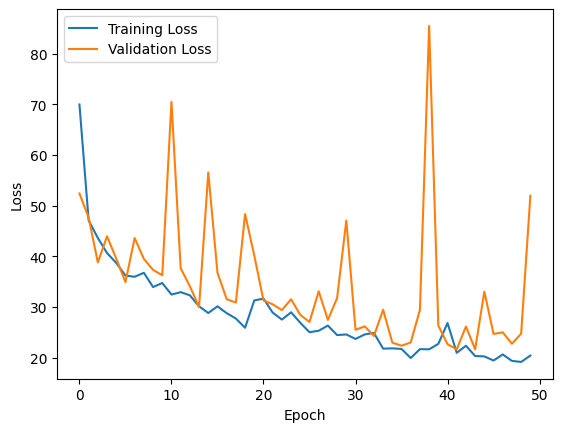

In [8]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
target_firing_rate_value = 10  

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

    
    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1)
            outputs, _, _ = net(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))  

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [12]:
print(outputs.shape)  # Should be [batch_size, num_classes]
print(labels.shape)    # Should be [batch_size]


torch.Size([32, 1])
torch.Size([32])


In [18]:
from torch.nn import BCEWithLogitsLoss

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = BCEWithLogitsLoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in range(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :].squeeze()  # Squeeze the output to shape [batch_size]
        loss = loss_fun(outputs, labels.float())  # Use float labels for BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

# Track all predictions and true labels
all_outputs = []
all_labels = []

# Validation phase
net.eval()
val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :].squeeze()  # Squeeze the output to shape [batch_size]
        loss = loss_fun(outputs, labels.float())  # Use float labels
        val_loss += loss.item()

        # Collect predictions and true labels
        all_outputs.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()

# Convert to numpy for metric calculations
y_pred_proba = all_outputs.numpy()
y_true = all_labels.numpy()

val_losses.append(val_loss / len(val_loader))

print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


Epoch 50/50, Training Loss: 0.5697396380721398, Validation Loss: 0.5542820351464408


In [21]:
import numpy as np

def calculate_metrics_at_threshold(outputs, labels, threshold):
    """
    Calculate False Detection Rate (FDR) and Miss Rate based on the firing threshold.
    
    Parameters:
    - outputs: Spike outputs from the SNN (shape: [n_samples, n_classes])
    - labels: True class labels (shape: [n_samples])
    - threshold: Firing threshold for classifying an output as a positive event
    
    Returns:
    - fdr: False Detection Rate
    - miss_rate: Miss Rate
    """
    # Apply threshold to outputs: 1 if neuron spike rate is above threshold, 0 otherwise
    predicted = (outputs > threshold).astype(int)
    
    # Assuming binary classification (0 and 1)
    tp = np.sum((predicted == 1) & (labels == 1))  # True Positives
    fp = np.sum((predicted == 1) & (labels == 0))  # False Positives
    fn = np.sum((predicted == 0) & (labels == 1))  # False Negatives
    tn = np.sum((predicted == 0) & (labels == 0))  # True Negatives
    
    # Calculate FDR and Miss Rate
    fdr = fp / (fp + tn) if (fp + tn) > 0 else 0
    miss_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return fdr, miss_rate


Vary the Firing Threshold and Calculate Metrics

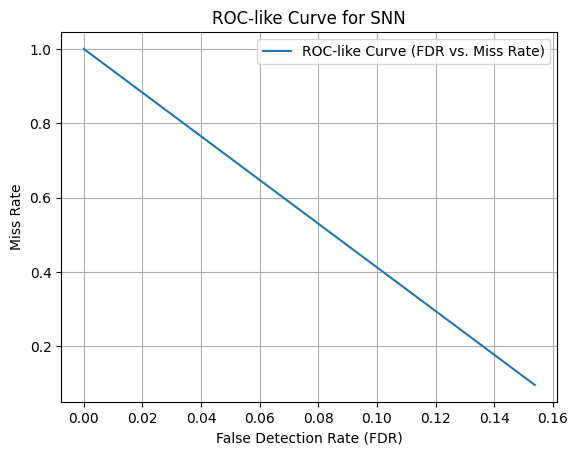

In [24]:
# Define thresholds to evaluate (e.g., vary from 0 to 1 with 50 steps)
thresholds = np.linspace(0, 1, 50)

fdr_values = []
miss_rate_values = []

# Loop over thresholds and calculate FDR and Miss Rate at each threshold
for threshold in thresholds:
    fdr, miss_rate = calculate_metrics_at_threshold(y_pred_proba, y_true, threshold)
    fdr_values.append(fdr)
    miss_rate_values.append(miss_rate)


# Plot FDR vs. Miss Rate
plt.plot(fdr_values, miss_rate_values, label='ROC-like Curve (FDR vs. Miss Rate)')
plt.xlabel('False Detection Rate (FDR)')
plt.ylabel('Miss Rate')
plt.title('ROC-like Curve for SNN')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Calculate AUC using the trapezoidal rule
auc_value = np.trapz(miss_rate_values, fdr_values)
print(f"Custom AUC: {auc_value:.2f}")


Custom AUC: -0.08
